#CafChem tools for training an embedding model, using it to calculate similarities and to featurize molecules for regression.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/Embeddings_CafChem.ipynb)

## This notebook allows you to:
- Create a contrastive pairs training dataset from a CSV.
- Train an embedding model.
- Calculate similarity with embeddings
- Featurize molecules with embeddings

## Requirements:
- This notebook will install rdkit and Sentence Transformers.
- Needs a GPU for training. Can run inference with CPU.

## Set up

### install libraries

In [3]:
!pip install -qU "sentence-transformers[train]"
!pip install -q rdkit

### Pull the CafChem libraries from Github and import libraries

In [1]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 876, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 876 (delta 128), reused 58 (delta 58), pack-reused 721 (from 3)
Receiving objects: 100% (876/876), 43.28 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (502/502), done.


In [3]:
import pandas as pd
import numpy as np
import random, os

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

os.environ['WANDB_DISABLED'] = 'true'

import CafChem.CafChemEmbed as cceb

## Read in data
- read in a CSV with classes and create a dataset for training, or
- read in a CSV with target values and create a dataset for training

### CSV with classes

In [4]:
df = pd.read_csv('/content/905_statins_3classes.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,Ligand SMILES,IC50 (nM),class labels
0,0,7,CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])=O)c(c...,0.106,0.106 < 15.0
1,1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200,0.106 < 15.0
2,2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300,0.106 < 15.0
3,3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300,0.106 < 15.0
4,4,12,COC(=O)C[C@H](O)C[C@H](O)\C=C\n1c(C(C)C)c(Br)c...,0.300,0.106 < 15.0


In [5]:
stat_data = cceb.embed_training_data(3)
stat_df, pairs_ds = stat_data.read_with_classes('/content/905_statins_3classes.csv', 'Ligand SMILES', 'class labels', [0,2])

Length of class 0.106 < 15.0: 296
Length of class 15.0 < 1000.0: 296
Length of class 1000.0 < 2488000.0: 296


Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
stat_df.head()

,premise,hypothesis,label
0,CCOc1cccc(CN(C)C(=O)c2nn(c(OC[C@@H](O)C[C@@H](...,Cc1cccc(c1)-c1cc(Cl)cc(Cl)c1\C=C\[C@@H]1C[C@@H...,0
1,CCOc1cccc(CN(C)C(=O)c2nn(c(OC[C@@H](O)C[C@@H](...,COc1cccc(CNC(=O)c2nn(c(OC[C@@H](O)C[C@@H](O)CC...,0
2,CCOc1cccc(CN(C)C(=O)c2nn(c(OC[C@@H](O)C[C@@H](...,CCC(C)(C)C(=O)O[C@H]1C[C@@H](C)[C@@H](OC(=O)N(...,0
3,CCOc1cccc(CN(C)C(=O)c2nn(c(OC[C@@H](O)C[C@@H](...,CC(C)c1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)n(nc1...,0
4,CCOc1cccc(CN(C)C(=O)c2nn(c(OC[C@@H](O)C[C@@H](...,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(-c2...,0


In [7]:
pairs_ds["train"][0]

{'premise': 'CC(C)c1c(C(=O)OCc2ccccc2)c(c(-c2ccc(F)cc2)n1CC[C@@H]1C[C@@H](O)CC(=O)O1)-c1ccccc1',
 'hypothesis': 'Cc1ccc(cc1)-c1cc(Cl)cc(Cl)c1\\C=C\\[C@@H]1C[C@@H](O)CC(=O)O1',
 'label': 0}

In [8]:
len(pairs_ds['train'])

148695

In [9]:
stat_df['label'].value_counts()

,count
label,
2,87616
0,87320


### CSV without classes

In [10]:
df = pd.read_csv('/content/905-unique-statins.csv')
df.head()

,Unnamed: 0,Ligand SMILES,IC50 (nM)
0,7,[Na+].CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])...,0.106
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300
4,12,COC(=O)C[C@H](O)C[C@H](O)\C=C\n1c(C(C)C)c(Br)c...,0.300


In [11]:
stat_data = cceb.embed_training_data(3)
stat_df, pairs_ds = stat_data.read_make_classes('/content/905-unique-statins.csv', 'IC50 (nM)', [0,2], 0.15)

Samples per class: 301, total samples:905
Length of class 0.106 < 15.0: 296
Length of class 15.0 < 1000.0: 296
Length of class 1000.0 < 2488000.0: 296


Generating train split: 0 examples [00:00, ? examples/s]

In [12]:
pairs_ds["train"][0]

{'premise': 'CC(C)c1nc(cc(-c2ccc(F)cc2)c1\\C=C\\[C@@H]1C[C@@H](O)CC(=O)O1)C(C)(C)C',
 'hypothesis': 'C[C@@H]1C[C@H](OC(=O)c2ccc(F)cc2)C2[C@@H](CC[C@@H]3C[C@@H](O)CC(=O)O3)[C@@H](C)C=CC2=C1',
 'label': 0}

In [13]:
len(pairs_ds['train'])

148695

In [14]:
stat_df['label'].value_counts()

,count
label,
2,87616
0,87320


## Train and test model

### Train

In [15]:
stat_model = cceb.embedding_model(pairs_ds["train"], pairs_ds["test"], 3, 2)
stat_model.set_up_model()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Model set-up complete.


In [16]:
stat_model.train_model()

dataset = dataset.select_columns(['hypothesis', 'entailment', 'contradiction'])


Step,Training Loss
100,0.742900
200,0.670200
300,0.640100
400,0.622700
500,0.608400
600,0.599100
700,0.578300
800,0.578300
900,0.560500
1000,0.572700


Model training complete.


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [57]:
stat_model.push_to_hub('cafierom/5Epoch_905_Statin_Contrastive')

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmp8x_9dz57/model.safetensors    :   0%|          |  558kB /  433MB            

Model saved to Huggingface Hub.


### Test trained model

In [17]:
test_df = pd.read_csv('/content/905-unique-statins.csv')
test_df.head()

,Unnamed: 0,Ligand SMILES,IC50 (nM)
0,7,[Na+].CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])...,0.106
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300
4,12,COC(=O)C[C@H](O)C[C@H](O)\C=C\n1c(C(C)C)c(Br)c...,0.300


In [18]:
test_df.sort_values(by='IC50 (nM)', inplace=True)
test_df.head()

,Unnamed: 0,Ligand SMILES,IC50 (nM)
0,7,[Na+].CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])...,0.106
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300
5,13,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300


In [19]:
ref_smiles = test_df['Ligand SMILES'].iloc[0]
test_smiles = test_df['Ligand SMILES'].iloc[1:6].tolist() + test_df['Ligand SMILES'].iloc[-5:].tolist()

print(test_smiles)
print(ref_smiles)

['CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c1C(=O)NCc1ccc(cc1)C#N)-c1ccccc1)-c1ccc(F)cc1', 'CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c1C(=O)Nc1cccc(c1)C(=O)N(C)C)-c1ccc(F)cc1)-c1ccc(F)cc1', 'CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2CCCN(c3ccccc3)C(=O)c12)-c1ccc(F)cc1', 'CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c1C(=O)Nc1ccc(cc1)C(O)=O)-c1ccccc1)-c1ccc(F)cc1', 'CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c1C(=O)Nc1ccc(cc1)C(N)=O)-c1ccccc1)-c1ccc(F)cc1', 'CCc1ccc(OCC(=O)OC)cc1', 'CC(CCc1ccc2oc3ccccc3c2c1)CC(O)=O', 'CCOC(=O)COc1cccc(CC)c1', 'CC(CC(O)=O)CC(=O)c1ccc(Oc2ccccc2)cc1', 'COc1cc(OC)c(\\C=C\\C)cc1OC']
[Na+].CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])=O)c(cn1C1CCCCC1)-c1ccc(F)cc1


In [20]:
sim = stat_model.similarity_scalar(test_smiles[-1], ref_smiles)
print(sim)

tensor([[0.0541]])


In [21]:
sim = stat_model.similarity_list(test_smiles, ref_smiles)
print(sim)

tensor([[ 0.4985],
        [ 0.6089],
        [ 0.9272],
        [ 0.7156],
        [ 0.7099],
        [-0.0875],
        [ 0.4734],
        [-0.0778],
        [ 0.6038],
        [ 0.0541]])


In [22]:
sim = stat_model.similarity_matrix(test_smiles)
for row in sim:
  row = row.tolist()
  for item in row:
    print(f"{item:8.4f}", end = ' ')
  print()

(10, 768)
  1.0000   0.9888   0.7631   0.9541   0.9564  -0.8391  -0.4495  -0.8343  -0.3193  -0.7667 
  0.9888   1.0000   0.8448   0.9872   0.9884  -0.7801  -0.3436  -0.7745  -0.2049  -0.6941 
  0.7631   0.8448   1.0000   0.9140   0.9107  -0.4079   0.1444  -0.3997   0.2912  -0.2808 
  0.9541   0.9872   0.9140   1.0000   0.9999  -0.6995  -0.2218  -0.6928  -0.0756  -0.6009 
  0.9564   0.9884   0.9107   0.9999   1.0000  -0.7045  -0.2293  -0.6979  -0.0833  -0.6066 
 -0.8391  -0.7801  -0.4079  -0.6995  -0.7045   1.0000   0.7898   0.9979   0.6909   0.9819 
 -0.4495  -0.3436   0.1444  -0.2218  -0.2293   0.7898   1.0000   0.7959   0.9721   0.8788 
 -0.8343  -0.7745  -0.3997  -0.6928  -0.6979   0.9979   0.7959   1.0000   0.6979   0.9851 
 -0.3193  -0.2049   0.2912  -0.0756  -0.0833   0.6909   0.9721   0.6979   1.0000   0.7932 
 -0.7667  -0.6941  -0.2808  -0.6009  -0.6066   0.9819   0.8788   0.9851   0.7932   1.0000 


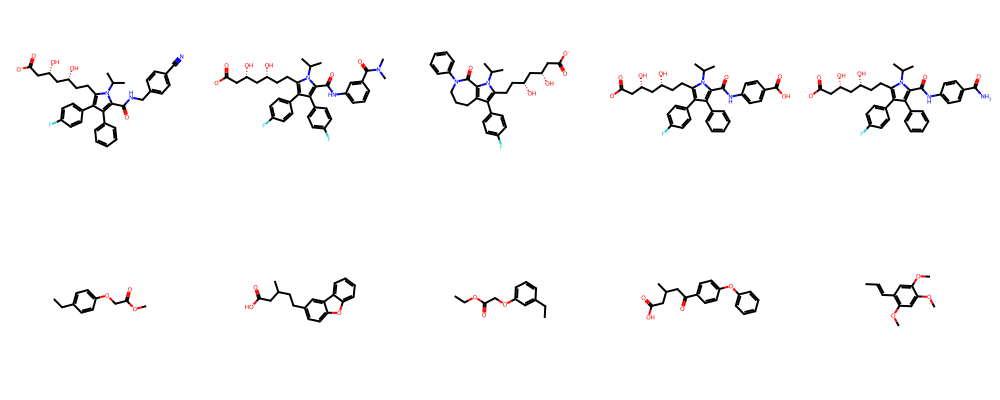

In [23]:
mols = [Chem.MolFromSmiles(smi) for smi in test_smiles]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
img

## Load model from Hub and test

### Load model from hub

In [25]:
stat_load_model = cceb.embedding_model(None, None, 3)

In [26]:
old_model = stat_load_model.load_model_from_hub('cafierom/905_Statin_Contrastive')

Model loaded from Huggingface Hub.


### get testing data

In [27]:
test_df = pd.read_csv('/content/905-unique-statins.csv')
test_df.head()

,Unnamed: 0,Ligand SMILES,IC50 (nM)
0,7,[Na+].CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])...,0.106
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300
4,12,COC(=O)C[C@H](O)C[C@H](O)\C=C\n1c(C(C)C)c(Br)c...,0.300


In [28]:
test_df.sort_values(by='IC50 (nM)', inplace=True)
test_df.head()

,Unnamed: 0,Ligand SMILES,IC50 (nM)
0,7,[Na+].CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])...,0.106
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300
5,13,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300


In [29]:
ref_smiles = test_df['Ligand SMILES'].iloc[0]
test_smiles = test_df['Ligand SMILES'].iloc[1:6].tolist() + test_df['Ligand SMILES'].iloc[-5:].tolist()

print(test_smiles)
print(ref_smiles)

['CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c1C(=O)NCc1ccc(cc1)C#N)-c1ccccc1)-c1ccc(F)cc1', 'CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c1C(=O)Nc1cccc(c1)C(=O)N(C)C)-c1ccc(F)cc1)-c1ccc(F)cc1', 'CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2CCCN(c3ccccc3)C(=O)c12)-c1ccc(F)cc1', 'CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c1C(=O)Nc1ccc(cc1)C(O)=O)-c1ccccc1)-c1ccc(F)cc1', 'CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c1C(=O)Nc1ccc(cc1)C(N)=O)-c1ccccc1)-c1ccc(F)cc1', 'CCc1ccc(OCC(=O)OC)cc1', 'CC(CCc1ccc2oc3ccccc3c2c1)CC(O)=O', 'CCOC(=O)COc1cccc(CC)c1', 'CC(CC(O)=O)CC(=O)c1ccc(Oc2ccccc2)cc1', 'COc1cc(OC)c(\\C=C\\C)cc1OC']
[Na+].CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])=O)c(cn1C1CCCCC1)-c1ccc(F)cc1


### Calculate similarities

In [30]:
sim = stat_load_model.similarity_scalar(test_smiles[-1], ref_smiles)
print(sim)

tensor([[-0.0314]])


In [31]:
sim = stat_load_model.similarity_list(test_smiles, ref_smiles)
print(sim)

tensor([[ 0.9989],
        [ 0.9986],
        [ 0.9992],
        [ 0.9991],
        [ 0.9991],
        [-0.0331],
        [-0.0316],
        [-0.0358],
        [-0.0262],
        [-0.0314]])


In [32]:
sim = stat_load_model.similarity_matrix(test_smiles)
for row in sim:
  row = row.tolist()
  for item in row:
    print(f"{item:8.4f}", end = ' ')
  print()

(10, 768)
  1.0000   0.9999   0.9998   0.9999   0.9999  -0.0393  -0.0377  -0.0418  -0.0321  -0.0372 
  0.9999   1.0000   0.9997   0.9997   0.9997  -0.0394  -0.0377  -0.0418  -0.0320  -0.0371 
  0.9998   0.9997   1.0000   0.9998   0.9997  -0.0391  -0.0374  -0.0416  -0.0318  -0.0370 
  0.9999   0.9997   0.9998   1.0000   1.0000  -0.0394  -0.0378  -0.0419  -0.0322  -0.0373 
  0.9999   0.9997   0.9997   1.0000   1.0000  -0.0395  -0.0379  -0.0420  -0.0324  -0.0375 
 -0.0393  -0.0394  -0.0391  -0.0394  -0.0395   1.0000   0.9993   0.9995   0.9959   0.9974 
 -0.0377  -0.0377  -0.0374  -0.0378  -0.0379   0.9993   1.0000   0.9992   0.9970   0.9979 
 -0.0418  -0.0418  -0.0416  -0.0419  -0.0420   0.9995   0.9992   1.0000   0.9954   0.9972 
 -0.0321  -0.0320  -0.0318  -0.0322  -0.0324   0.9959   0.9970   0.9954   1.0000   0.9990 
 -0.0372  -0.0371  -0.0370  -0.0373  -0.0375   0.9974   0.9979   0.9972   0.9990   1.0000 


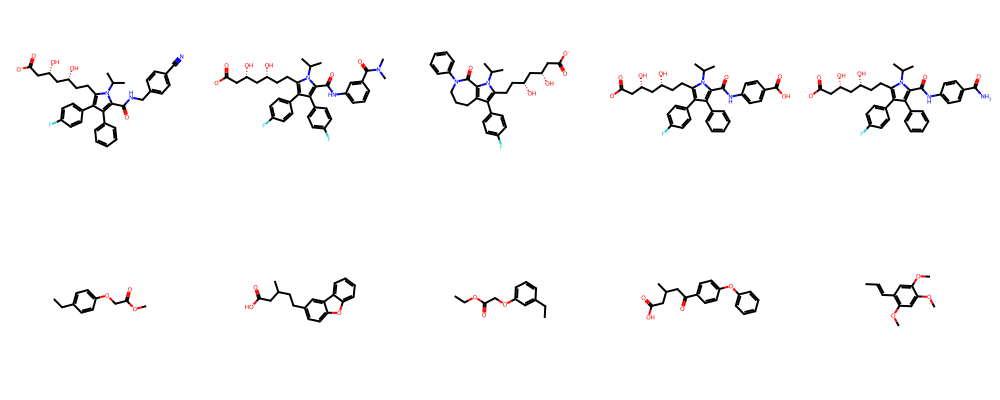

In [33]:
mols = [Chem.MolFromSmiles(smi) for smi in test_smiles]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
img

## Use embeddings as featues

In [34]:
stat_load_model = cceb.embedding_model(None, None, 3)
old_model = stat_load_model.load_model_from_hub('cafierom/905_Statin_Contrastive')

test_df = pd.read_csv('/content/905-unique-statins.csv')
test_df.head()

Model loaded from Huggingface Hub.


,Unnamed: 0,Ligand SMILES,IC50 (nM)
0,7,[Na+].CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])...,0.106
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300
4,12,COC(=O)C[C@H](O)C[C@H](O)\C=C\n1c(C(C)C)c(Br)c...,0.300


In [35]:
test_smiles = test_df['Ligand SMILES'].tolist()
test_smiles = test_smiles[:500]

df_embed, test_embeddings = stat_load_model.embed_and_featurize(test_smiles)
print(test_embeddings.shape)

(500, 768)


In [37]:
target_list = test_df['IC50 (nM)'].tolist()
target_list = target_list[:500]

X_train, X_valid, y_train, y_valid, smiles_train, smiles_valid, pca, scaler = cceb.scale_pca_split(test_embeddings, target_list, test_smiles, use_scaler = False, use_pca = False)

Pre-processing done.


In [38]:
rf_model = cceb.tree_regression(method = "forest", n_estimators = 100, max_depth = None,
               min_samples_split = 2, min_samples_leaf = 1, max_features = 1.0,
               learning_rate = 0.1)

Tree regression class initialized.


In [39]:
rf = rf_model.fit(X_train, X_valid, y_train, y_valid)

model selected:  RandomForest
fit model in: 0.6025637333000001 minutes
score for training set:  0.9109897725195941
score for validation set:  0.4378966907888444


In [40]:
df_embed.to_csv('statin_embeddings.csv', index=False)